In [206]:
import os
import sys
sys.path.append('..')
sys.path.append('../src')

import pandas as pd
import torch
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import decode_image

import matplotlib.pyplot as plt

from src.image_process import show_image, load_image_and_metadata, segement_per_bbox
from src.image_encoder import PreTrainedImageEncoder

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Creation:

Create an image embedding model by employing pre-trained **ResNet50** model, and removing its last two layers (Average Pooling Layer and Full Connected Layer). 

There are several choices to post-process the direct output of the embedding model (i.e. a (2048, 7, 7) tensor). An easy start is using Global average pooling (GAP) to convert the output as a 2048-length vector.

## 1. Create Image Encoder using Pre-trained ResNet50

In [3]:
# cache weights to a project folder
os.environ['TORCH_HOME'] = '../cache'
# Init model with pre-trained weights
pre_trained_weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=pre_trained_weights)

In [4]:
image_encoder = PreTrainedImageEncoder(model)

In [5]:
# Set encoder to eval mode
image_encoder.eval()

print("Image encoder loaded.")

Image encoder loaded.


In [6]:
# Init transforms
image_process = pre_trained_weights.transforms()
image_process

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## 2. Test the Encoder with an Image

Select a customer-shop image pair, and another shop image. Calculate the similarities.

The Cosine similarity is used, which is effective to compare similarity of clothes patterns.

In [288]:
img_dir = '../data/validation/image'
metadata_dir = '../data/validation/annos'

In [289]:
img_1, bboxes_1, pair_id_1 = load_image_and_metadata(
    '000345', image_dir=img_dir, metadata_dir=metadata_dir
)
img_2, bboxes_2, pair_id_2 = load_image_and_metadata(
    '011443', image_dir=img_dir, metadata_dir=metadata_dir
)
img_3, bboxes_3, pair_id_3 = load_image_and_metadata(
    '011445', image_dir=img_dir, metadata_dir=metadata_dir
)

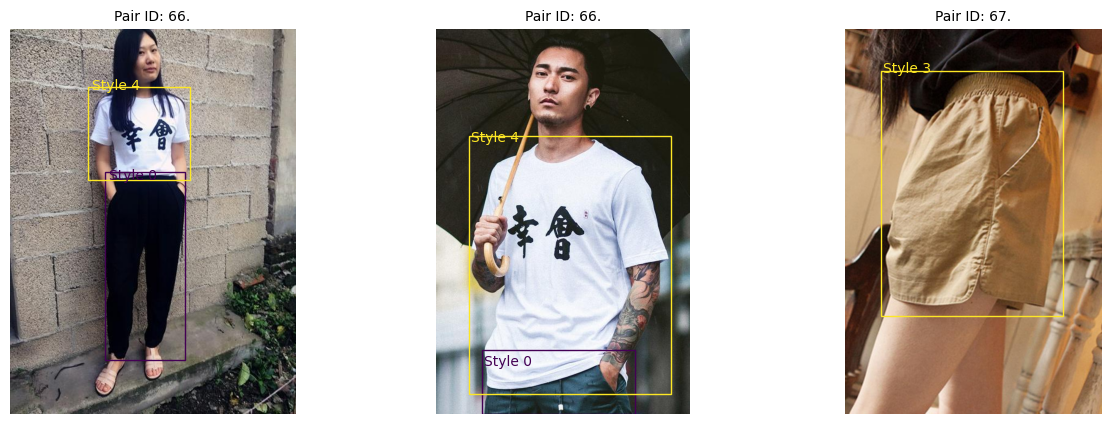

In [292]:
num_images = 3
image_tensors = [img_1, img_2, img_3]
bboxes = [bboxes_1, bboxes_2, bboxes_3]
pair_ids = [pair_id_1, pair_id_2, pair_id_3]

fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))
for i in range(num_images):
    show_image(image_tensors[i], bboxes=bboxes[i], pair_id=pair_ids[i], ax=axes[i])

In [295]:
# Encode these three images, then compute similarity
img_tensors = torch.stack(
    [image_process(img_1), image_process(img_2), image_process(img_3)], 
    dim=0
)

img_tensors.size()

torch.Size([3, 3, 224, 224])

In [296]:
with torch.no_grad():
    model_output = image_encoder(
        img_tensors
    )

In [297]:
# compute cosine similarity
cos_sim_1_2 = F.cosine_similarity(model_output[0], model_output[1], dim=0)
cos_sim_1_3 = F.cosine_similarity(model_output[0], model_output[2], dim=0)
print(f"Similarity between image 1 and 2: {cos_sim_1_2};\nSimilarity between image 1 and 3: {cos_sim_1_3}.")

Similarity between image 1 and 2: 0.26707327365875244;
Similarity between image 1 and 3: 0.18015779554843903.


In [298]:
# Segment image by bounding boxes
img_1_seg = segement_per_bbox(img_1, bboxes_1[4])
img_2_seg = segement_per_bbox(img_2, bboxes_2[4])
img_3_seg = segement_per_bbox(img_3, bboxes_3[3])

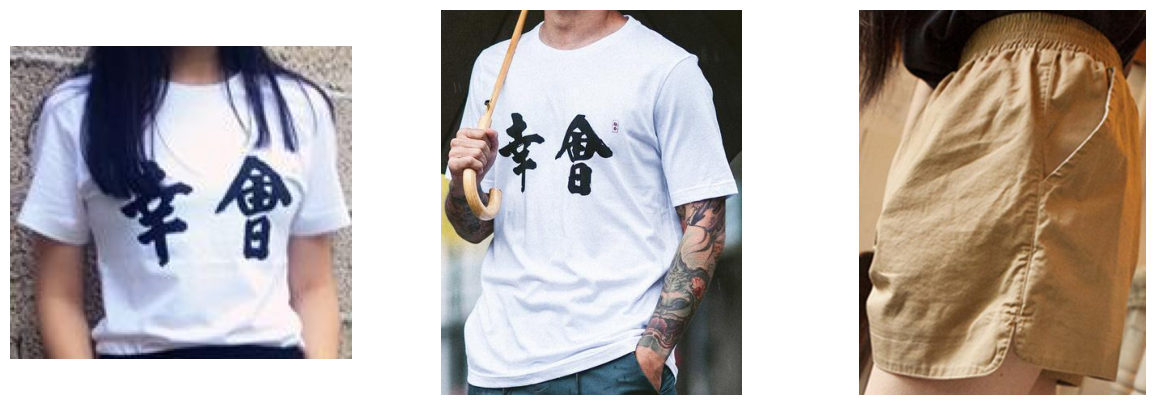

In [299]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
for i, img in enumerate([img_1_seg, img_2_seg, img_3_seg]):
    show_image(img, ax=axes[i])

In [300]:
img_tensors = torch.stack(
    [image_process(img_1_seg), image_process(img_2_seg), image_process(img_3_seg)], 
    dim=0
)

with torch.no_grad():
    model_output = image_encoder(
        img_tensors
    )

In [301]:
# compute cosine similarity
cos_sim_1_2 = F.cosine_similarity(model_output[0], model_output[1], dim=0)
cos_sim_1_3 = F.cosine_similarity(model_output[0], model_output[2], dim=0)
print(f"Similarity between image 1 and 2: {cos_sim_1_2};\nSimilarity between image 1 and 3: {cos_sim_1_3}.")

Similarity between image 1 and 2: 0.4149670898914337;
Similarity between image 1 and 3: 0.2793825566768646.


In [ ]:
# Next step:
# 4. Embed the image database using FAISS
# 5. Try to retrieve an image
# 6. Design an evaluation pipeline: metrics; pipeline code.

In [ ]:
def create_image_database():

    # get image metadata: which images to be encoded. Basically all shop images

    # for each image, 
        # direct encoding
            # pass to image_encoder (by batch)
            # save vectors, with pair_id, style_ids (a list), image_id as metadata

        
        # Save vectors and metadata in vector database

    # Create a retrievor and ranker that accepts 